In [1]:
import tensorflow as tf

/Users/nikilsaldanaha/Documents/Code/MLNotebooks/env/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
import numpy as np

In [3]:
# Creating some random 3D dataset

np.random.seed(4)
m = 200
noise = np.random.normal(0,1e-3,200)

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
data = np.empty((200, 3))
data[:, 0] = np.cos(angles) - np.sin(angles)
data[:, 1] = np.cos(angles) - np.sin(angles)
data[:, 2] = np.cos(angles) * np.sin(angles)

In [4]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(data[:100])
X_test = scaler.transform(data[100:])

In [5]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
def plot_image(image, shape=[28, 28]):
    plt.imshow(image.reshape(shape), cmap="Greys", interpolation="nearest")
    plt.axis("off")

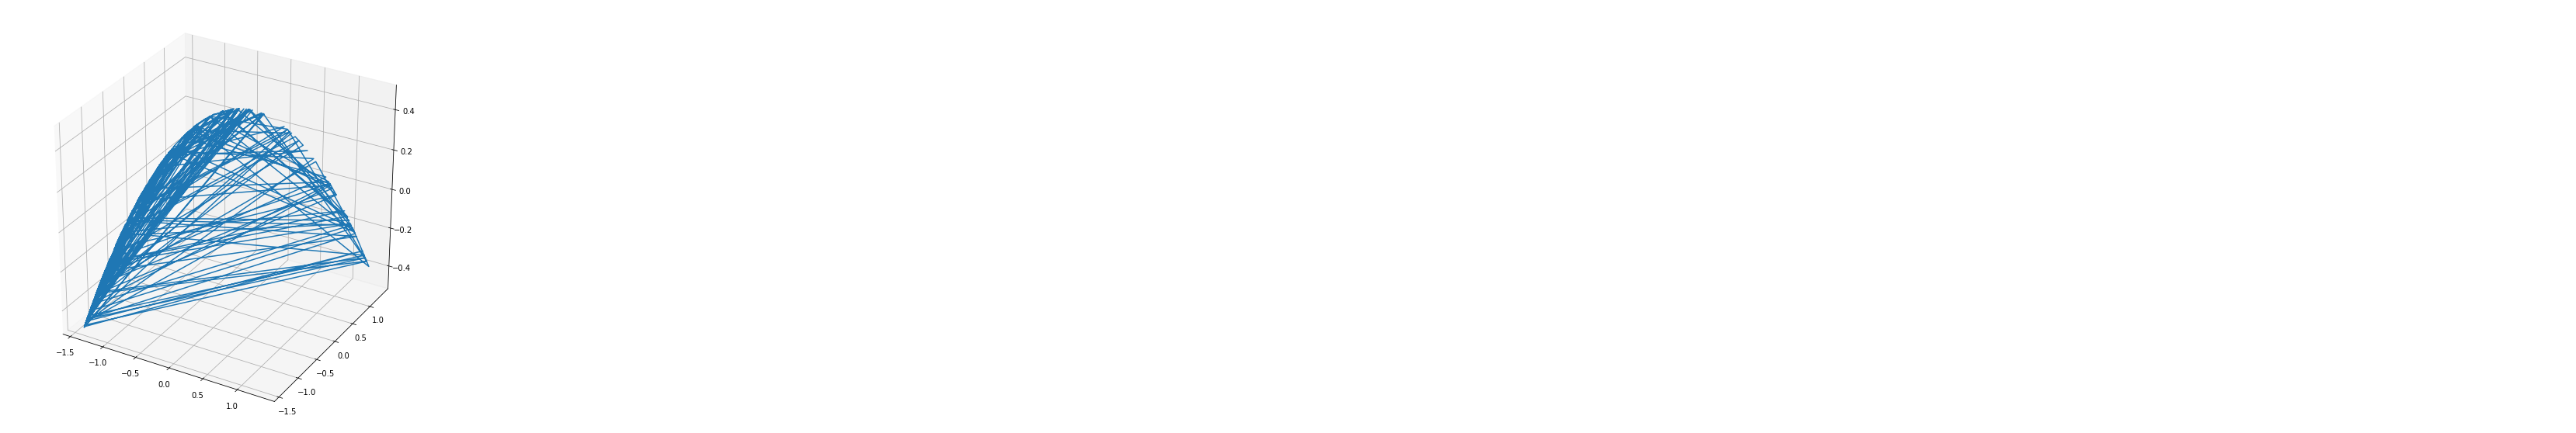

In [7]:
fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')
ax.plot(data[:,0], data[:, 1], data[:, 2])

## Undercomplete Linear Autoencoder

When autoencoders use only linear activations, then they end up performing PCA on 3D data.

In theory the auto-encoder should be able to figure out the underlying structure in the 3D dataset above

In [8]:
n_inputs = 3
n_hidden = 2
learning_rate = 0.01

In [9]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
# single layer with lower dimension than input that learns concise representation
hidden = tf.layers.dense(X, n_hidden)
# output layer size is same as input layer size
outputs = tf.layers.dense(hidden, n_inputs)

In [10]:
# MSE Loss
reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)

init = tf.global_variables_initializer()

In [11]:
n_iterations = 1000

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        training_op.run(feed_dict={X: X_train})
    hidden_val = hidden.eval(feed_dict={X: X_test})

Text(0, 0.5, '$z_2$')

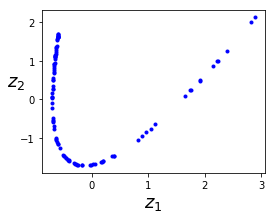

In [12]:
fig = plt.figure(figsize=(4,3))
plt.plot(hidden_val[:,0], hidden_val[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)

## MNIST Dataset


It was able to find some structure, but we're not if it was correct

Trying out the autoencoder on a more standard dataset that is easily interpretable may give some insight

We will not allow the auto-encoder to simply copy the digit from input to output. Rather, we will impose
some contstrains by making the hidden layer of significantly lower dimensions than the preceeding and succeeding layers. Theoretically, this should allow the AE to learn the reconstruct the digits even when they are vague.

In [13]:
tf.reset_default_graph()

In [14]:
(X_train, _), (X_test, _) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0

In [15]:
n_inputs = 28 * 28
n_hidden_1 = 500
n_hidden_2 = 10 # constrained hidden layer(representation layer)
n_hidden_3 = n_hidden_1
n_outputs = n_inputs

learning_rate = 0.001
l2_reg = 0.0001

X = tf.placeholder(tf.float32, shape=(None, n_inputs))
he_init = tf.initializers.variance_scaling()

l2_regularizer = tf.contrib.layers.l2_regularizer(l2_reg)

hidden1 = tf.layers.dense(X, n_hidden_1,activation=tf.nn.elu, kernel_initializer=he_init, bias_regularizer=l2_regularizer) 
hidden2 = tf.layers.dense(hidden1, n_hidden_2,activation=tf.nn.elu, kernel_initializer=he_init, bias_regularizer=l2_regularizer)
hidden3 = tf.layers.dense(hidden2, n_hidden_3, activation=tf.nn.elu, kernel_initializer=he_init, bias_regularizer=l2_regularizer)
outputs = tf.layers.dense(hidden3, n_outputs, activation=None, kernel_initializer=he_init, bias_regularizer=l2_regularizer)

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))
reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
loss = tf.add_n([reconstruction_loss] + reg_losses)

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init_op = tf.global_variables_initializer()
saver = tf.train.Saver()

In [16]:
def shuffle_batch(X, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch = X[batch_idx]
        
        yield X_batch

In [20]:
n_epochs = 50
batch_size = 150

with tf.Session() as sess:
    init_op.run()
    for epoch in range(n_epochs):
#         n_batches = mnist.train.num_examples // batch_size
        for X_batch in shuffle_batch(X_train, batch_size):
#             print("\r{}%".format(100 * iteration // n_batches), end="")
#             X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train MSE:", loss_train)
        saver.save(sess, "tf_logs/ae-model2.ckpt")

0 Train MSE: 0.035267234
1 Train MSE: 0.02964483
2 Train MSE: 0.026071029
3 Train MSE: 0.025825191
4 Train MSE: 0.023912812
5 Train MSE: 0.024459423
6 Train MSE: 0.023594959
7 Train MSE: 0.026294282
8 Train MSE: 0.022887582
9 Train MSE: 0.021917935
10 Train MSE: 0.02317992
11 Train MSE: 0.022694154
12 Train MSE: 0.021521732
13 Train MSE: 0.021852292
14 Train MSE: 0.02160761
15 Train MSE: 0.021634389
16 Train MSE: 0.019747224
17 Train MSE: 0.020261176
18 Train MSE: 0.021360252
19 Train MSE: 0.020937733
20 Train MSE: 0.020767506
21 Train MSE: 0.021072522
22 Train MSE: 0.020688886
23 Train MSE: 0.02059892
24 Train MSE: 0.020436289
25 Train MSE: 0.02039837
26 Train MSE: 0.02001444
27 Train MSE: 0.02029955
28 Train MSE: 0.020595344
29 Train MSE: 0.019305909
30 Train MSE: 0.019219471
31 Train MSE: 0.020684993
32 Train MSE: 0.020021835
33 Train MSE: 0.019130334
34 Train MSE: 0.019083472
35 Train MSE: 0.019823907
36 Train MSE: 0.019999066
37 Train MSE: 0.018895032
38 Train MSE: 0.01921339
39 T

In [17]:
def show_reconstructed_digits(X, outputs, model_path = None, index=None):
    with tf.Session() as sess:
        if model_path:
            saver.restore(sess, model_path)
        outputs_val = outputs.eval(feed_dict={X: X_test})

    fig = plt.figure(figsize=(8, 3))
    if index is None:
        index = np.random.randint(0, high=X_test.shape[0])
    print(index)
    plt.subplot(1, 2, 1)
    plot_image(X_test[index])
    plt.subplot(1, 2, 2)
    plot_image(outputs_val[index])

### Some interestingly constructed digits

We see below some of the digits that have been reconstructed by the AutoEncoder.
I have highlighted some of the more interesting ones below

INFO:tensorflow:Restoring parameters from tf_logs/ae-model2.ckpt
4508


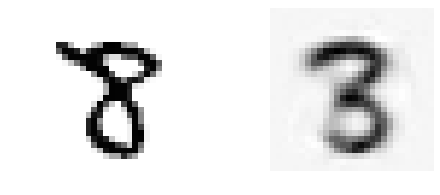

In [18]:
show_reconstructed_digits(X, outputs, "tf_logs/ae-model2.ckpt", 4508)
# save_fig("reconstruction_plot")

INFO:tensorflow:Restoring parameters from tf_logs/ae-model2.ckpt
7047


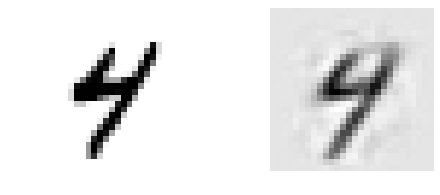

In [19]:
show_reconstructed_digits(X, outputs, "tf_logs/ae-model2.ckpt", 7047)

INFO:tensorflow:Restoring parameters from tf_logs/ae-model2.ckpt
5593


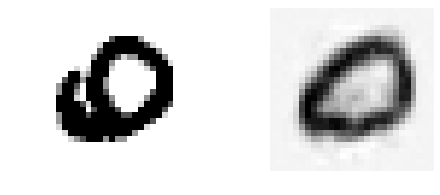

In [20]:
show_reconstructed_digits(X, outputs, "tf_logs/ae-model2.ckpt", 5593)

INFO:tensorflow:Restoring parameters from tf_logs/ae-model2.ckpt
8246


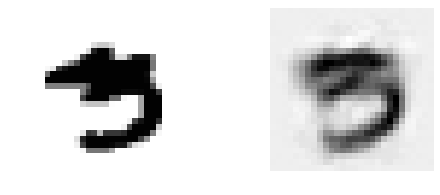

In [21]:
show_reconstructed_digits(X, outputs, "tf_logs/ae-model2.ckpt", 8246)